# 彩票预测
本项目使用RNN进行彩票预测。

使用人工智能技术来预测彩票，是这次的主题，那么预测哪种彩票呢？我们先选择简单一些的，就是排列组合少一些的，如果证明我们的模型work，再扩展到其他的彩票上。最终我选择了[`排列三`](https://baike.baidu.com/item/排列三/343981?fr=aladdin), 从000-999的数字中选取1个3位数，一共有1000种，中奖概率就是千分之一，够简单了吧。

历史数据在[`这里`](https://datachart.500.com/)。

数据是按照每期一组数的顺序排列的，从第一期到最新的一期，实际上是时间序列的数据。跟回归预测有很大的区别，因为特征上没有特殊的意义，不具备一组特征x映射到label y的条件。但是按照时间序列来训练的话就不一样了，输入x是一期的开奖结果，要学习的y是下一期的开奖结果。

彩票的开奖结果是一个随机分布，跟投骰子、抛硬币差不多，从数学角度看没有规律可言。我的预期是，虽然数学模型是随机的，但是一旦跟现实世界的物体发生关系，总会受到某种影响吧，比如量子纠缠，万有引力，动力学，空气阻力，空气湿度，开奖时刻的机器电压强度，开奖器材的损耗，每个球的质量的差异，吹球设备的物理特性，装球器皿的特定形状等等因素所产生的规律性的东西。

看得出来以上所列出的和没列出的都是增加不确定性、随机性的因素，但是也有可能每次开奖这些相同的特点可能造成某种规律性的结果出来，比如根据这些物理特性的影响，某个球特别容易开出来。一旦是这样，那么就有迹可循，让我们的学习器学到规律。




## LSTM介绍
我们需要从过往的历史数据中寻找规律，[`LSTM`](https://en.wikipedia.org/wiki/Long_short-term_memory)再适合不过了。如果你对LSTM不熟悉的话，以下几篇文章建议你阅读：

[`Understanding LSTM Networks`](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[`[译] 理解 LSTM 网络`](http://www.jianshu.com/p/9dc9f41f0b29)

[`RNN以及LSTM的介绍和公式梳理`](http://blog.csdn.net/Dark_Scope/article/details/47056361)


## 辅助函数
 - `load_data` 加载数据集
 - `preprocess_and_save_data` 数据集预处理，将每期号码转成字典

In [1]:
import tensorflow as tf
import os
import pickle

def load_data(path):
    """
    Load Dataset from File
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data

def preprocess_and_save_data(dataset_path, create_lookup_tables):
    """
    Preprocess Text Data
    """
    text = load_data(dataset_path)
    
    text = text.lower()
    #text = text.split()
    
    words = [word for word in text.split()]

    reverse_words = [text.split()[idx] for idx in (range(len(words)-1, 0, -1))]
    vocab_to_int, int_to_vocab = create_lookup_tables()#text
    #int_text = [vocab_to_int[word] for word in text]
    int_text = [vocab_to_int[word] for word in reverse_words]
    pickle.dump((int_text, vocab_to_int, int_to_vocab), open('preprocess.p', 'wb'))


def load_preprocess():
    """
    Load the Preprocessed Training data and return them in batches of <batch_size> or less
    """
    return pickle.load(open('preprocess.p', mode='rb'))

def save_params(params):
    """
    Save parameters to file
    """
    pickle.dump(params, open('params.p', 'wb'))


def load_params():
    """
    Load parameters from file
    """
    return pickle.load(open('params.p', mode='rb'))


/Applications/anaconda/envs/tf1.8/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


## 加载数据集

In [2]:
data_dir = './data/cp.txt'
text = load_data(data_dir)

## 看看数据集的结构
可以修改 `view_sentence_range` 用来查看数据集的不同部分。

In [3]:
view_sentence_range = (0, 10)

import numpy as np

print('数据情况：')
print('不重复单词(彩票开奖记录)的个数: {}'.format(len({word: None for word in text.split()})))
scenes = text.split('\n\n')
sentence_count_scene = [scene.count('\n') for scene in scenes]
print('开奖期数: {}期'.format(int(np.average(sentence_count_scene))))

sentences = [sentence for scene in scenes for sentence in scene.split('\n')]
print('行数: {}'.format(len(sentences)))
word_count_sentence = [len(sentence.split()) for sentence in sentences]
print('平均每行单词数: {}'.format(np.ceil(np.average(word_count_sentence))))

print()
print('开奖记录从 {} 到 {}:'.format(*view_sentence_range))
print('\n'.join(text.split('\n')[view_sentence_range[0]:view_sentence_range[1]]))

数据情况：
不重复单词(彩票开奖记录)的个数: 988
开奖期数: 4656期
行数: 4657
平均每行单词数: 1.0

开奖记录从 0 到 10:
202
243
580
306
598
900
761
262
891
623


一共4656条记录，4600多期了。共出现了988个不重复的结果，就是说还有（1000 – 988）12组数到现在还没有开出来过。文件中第一行是最新的一期，第二行是之前的一期，。。。，最后一行是第一期。

我们可以把三个数组合成一组数，就像数据集中体现的那样，并且把一组数当作一个数或者说当作一个单词。这样在预处理数据集的时候会简单一些，从索引到单词（0 -> ‘000’）和从单词到索引（‘012’-> 12）其实都是同一个数。

## 预测网络介绍

网络的输入是每一期的开奖结果，总共有1000组数，用one hot编码是一个1000维的稀疏向量：

<img src="assets/v2-09e1bda72c4b903e25db203ab4aa6dc6_hd.jpg">

使用one hot稀疏向量在输入层与网络第一层做矩阵乘法时会很没有效率，因为向量里面大部分都是0， 矩阵乘法浪费了大量的计算，最终矩阵运算得出的结果是向量中值为1的列所对应的矩阵中的行向量。
<img src="assets/lookup_matrix.png">
图片[`来源`](https://github.com/udacity/cn-deep-learning/blob/master/tutorials/embeddings/assets/lookup_matrix.png)

这看起来很像用索引查表一样，one hot向量中值为1的位置作为下标，去索引参数矩阵中的行向量。

为了代替矩阵乘法，我们将参数矩阵当作一个查找表（lookup table）或者叫做嵌入矩阵（embedding matrix），将每组开奖数据所对应的数作为索引，比如“958”，对应索引就是958，然后在查找表中找第958行。
<img src="assets/tokenize_lookup.png">
这其实跟替换之前的模型没有什么不同，嵌入矩阵就是参数矩阵，嵌入层仍然是隐层。查找表只是矩阵乘法的一种便捷方式，它会像参数矩阵一样被训练，是要学习的参数。

下面就是我们要构建的网络架构，从嵌入层输出的向量进入LSTM层进行时间序列的学习，然后经过softmax预测出下一期的开奖结果。
<img src="assets/network_diagram.png">

网络训练的代码，使用了几个trick，在下文<[`构建计算图`](#构建计算图)>和<[`训练`](#训练)>章节会做说明，<[`结论`](#结论)>在最后。

几个图表的位置：

- [`真实值在预测值中的距离图表`](#真实值在预测值中的距离图表)
- [`显示训练Loss`](#显示训练Loss)
- [`显示测试Loss`](#显示测试Loss)
- [`显示准确率`](#显示准确率)
- [`显示预测结果和实际开奖结果`](#显示预测结果和实际开奖结果)
- [`生成往期开奖结果的相似度分布`](#生成往期开奖结果的相似度分布)

## 编码实现

### 实现数据预处理
首先要做的事是对数据进行预处理，要实现下面的函数：
- Lookup Table

### Lookup Table
使用词向量之前，我们需要先准备好单词(彩票开奖记录)和ID之间的转换关系。在这个函数中，创建并返回两个字典：
- 单词到ID的转换字典： `vocab_to_int`
- ID到单词的转换字典： `int_to_vocab`


In [4]:
import numpy as np
from collections import Counter

def create_lookup_tables():
    """
    Create lookup tables for vocabulary
    :param text: The text of tv scripts split into words
    :return: A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    vocab_to_int = {str(ii).zfill(3) : ii for ii in range(1000)}
    int_to_vocab = {ii : str(ii).zfill(3) for ii in range(1000)}
    return vocab_to_int, int_to_vocab


### 处理所有数据并保存
将每期结果按照从第一期开始的顺序保存到文件中。

In [5]:
# Preprocess Training, Validation, and Testing Data
preprocess_and_save_data(data_dir, create_lookup_tables)

### Check Point
这是第一个存档点，如果你想读档或者这个notebook重启了的话，你可以从这里开始。预处理的数据已经保存在磁盘上了。

In [6]:
import numpy as np

int_text, vocab_to_int, int_to_vocab = load_preprocess()

## 构建神经网络
要构建RNN，我们来实现如下几个函数：
- get_inputs
- get_init_cell
- get_embed
- build_rnn
- build_nn
- get_batches


### 输入

In [7]:
def get_inputs():
    """
    Create TF Placeholders for input, targets, and learning rate.
    :return: Tuple (input, targets, learning rate)
    """
    inputs = tf.placeholder(tf.int32, [None, None], name="input")
    targets = tf.placeholder(tf.int32, [None, None], name="targets")
    LearningRate = tf.placeholder(tf.float32)
    return inputs, targets, LearningRate

### 构建RNN单元并初始化
将一个或多个[`BasicLSTMCells`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/BasicLSTMCell) 叠加在[`MultiRNNCell`](https://www.tensorflow.org/api_docs/python/tf/contrib/rnn/MultiRNNCell)中，这里我们使用2层LSTM cell。

In [8]:
def get_init_cell(batch_size, rnn_size):
    """
    Create an RNN Cell and initialize it.
    :param batch_size: Size of batches
    :param rnn_size: Size of RNNs
    :return: Tuple (cell, initialize state)
    """
    cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=rnn_size) for _ in range(2)])
    InitialState = cell.zero_state(batch_size, tf.float32)
    InitialState = tf.identity(InitialState, name="initial_state")
    return cell, InitialState


### 词嵌入
 - embed_matrix是嵌入矩阵，后面计算相似度(距离)的时候会用到。
 - embed_layer是从嵌入矩阵（查找表）中索引到的向量。
 

In [9]:
def get_embed(input_data, vocab_size, embed_dim):
    """
    Create embedding for <input_data>.
    :param input_data: TF placeholder for text input.
    :param vocab_size: Number of words in vocabulary.
    :param embed_dim: Number of embedding dimensions
    :return: Tuple (Embedded input, embed_matrix)
    """
    embed_matrix = tf.Variable(tf.random_uniform([vocab_size, embed_dim], -1, 1))
    embed_layer = tf.nn.embedding_lookup(embed_matrix, input_data)
    return embed_layer, embed_matrix


### 构建RNN
我们在`get_init_cell()`函数中创建了RNN单元，是时候使用这些单元创建RNN了。

In [10]:
def build_rnn(cell, inputs):
    """
    Create a RNN using a RNN Cell
    :param cell: RNN Cell
    :param inputs: Input text data
    :return: Tuple (Outputs, Final State)
    """
    Outputs, final_State = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    final_State = tf.identity(final_State, name="final_state")
    return Outputs, final_State


### 创建神经网络
- 使用 `get_embed(input_data, vocab_size, embed_dim)` 函数将 `input_data` 应用在嵌入层中。
- 使用 `cell` 和 `build_rnn(cell, inputs)` 函数创建RNN 。
- 使用具有线性激活函数的全连接层，将 `vocab_size` 作为输出的维度。

In [11]:
def build_nn(cell, rnn_size, input_data, vocab_size, embed_dim):
    """
    Build part of the neural network
    :param cell: RNN cell
    :param rnn_size: Size of rnns
    :param input_data: Input data
    :param vocab_size: Vocabulary size
    :param embed_dim: Number of embedding dimensions
    :return: Tuple (Logits, FinalState, embed_matrix)
    """
    embed_layer, embed_matrix = get_embed(input_data, vocab_size, embed_dim)
    Outputs, final_State = build_rnn(cell, embed_layer)
    logits = tf.layers.dense(Outputs, vocab_size)
    return logits, final_State, embed_matrix


### Batches
使用 `int_text` 实现 `get_batches` 函数用来创建输入和目标的批量数据batches。   
每一个batch包含两个元素：
- 第一个元素是形状为 `[batch size, sequence length]` 的输入batch。
- 第二个元素是形状为 `[batch size, sequence length]` 的目标batch。

如果最后的数据不够组成一个batch的话，则抛弃这些数据。

举个栗子, `get_batches([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 2, 3)` 应该返回如下的Numpy数组：
```
[
  # First Batch
  [
    # Batch of Input
    [[ 1  2  3], [ 7  8  9]],
    # Batch of targets
    [[ 2  3  4], [ 8  9 10]]
  ],
 
  # Second Batch
  [
    # Batch of Input
    [[ 4  5  6], [10 11 12]],
    # Batch of targets
    [[ 5  6  7], [11 12 13]]
  ]
]
```

In [12]:
def get_batches(int_text, batch_size, seq_length):
    """
    Return batches of input and target
    :param int_text: Text with the words replaced by their ids
    :param batch_size: The size of batch
    :param seq_length: The length of sequence
    :return: Batches as a Numpy array
    """
    batchCnt = len(int_text) // (batch_size * seq_length)
    int_text_inputs = int_text[:batchCnt * (batch_size * seq_length)]
    int_text_targets = int_text[1:batchCnt * (batch_size * seq_length)+1]

    result_list = []
    x = np.array(int_text_inputs).reshape(1, batch_size, -1)
    y = np.array(int_text_targets).reshape(1, batch_size, -1)

    x_new = np.dsplit(x, batchCnt)
    y_new = np.dsplit(y, batchCnt)

    for ii in range(batchCnt):
        x_list = []
        x_list.append(x_new[ii][0])
        x_list.append(y_new[ii][0])
        result_list.append(x_list)

    return np.array(result_list)


# get_batches([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 2, 3)

## 训练神经网络
### 超参
调整如下参数：

-  `num_epochs` 设置训练几代。
-  `batch_size` 是批次大小。
-  `rnn_size` 是RNN的大小（隐藏节点的维度）。
-  `embed_dim` 是嵌入层的维度。
-  `seq_length` 是序列的长度，始终为1。
-  `learning_rate` 是学习率。
-  `show_every_n_batches` 是过多少batch以后打印训练信息。

In [13]:
# Number of Epochs
num_epochs = 50
# Batch Size
batch_size = 32
# RNN Size
rnn_size = 512
# Embedding Dimension Size
embed_dim = 512
# Sequence Length
seq_length = 1
# Learning Rate
learning_rate = 0.01
# Show stats for every n number of batches
show_every_n_batches = 10

save_dir = './save'

下面代码是计算softmax交叉熵的损失函数，没有使用。

In [120]:
# def build_loss(logits, targets, num_classes):
#     ''' Calculate the loss from the logits and the targets.
    
#         Arguments
#         ---------
#         logits: Logits from final fully connected layer
#         targets: Targets for supervised learning
#         num_classes: Number of classes in targets
        
#     '''
#     y_one_hot = tf.one_hot(tf.squeeze(targets), num_classes)
#     y_reshaped = tf.reshape(y_one_hot, (batch_size, num_classes))
    
#     # Softmax cross entropy loss
#     loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_reshaped)
#     loss = tf.reduce_mean(loss)
#     return loss

### 构建计算图
使用实现的神经网络构建计算图。

损失cost：损失函数没有使用softmax交叉熵，而是使用了sequence loss。

使用normalized_embedding做相似度上距离的计算。

In [14]:
from tensorflow.contrib import seq2seq

tf.reset_default_graph()
train_graph = tf.Graph()
with train_graph.as_default():
    vocab_size = len(int_to_vocab)
    input_text, targets, lr = get_inputs()
    input_data_shape = tf.shape(input_text)
    cell, initial_state = get_init_cell(input_data_shape[0], rnn_size)
    logits, final_state, embed_matrix = build_nn(cell, rnn_size, input_text, vocab_size, embed_dim)

    # Probabilities for generating words
    probs = tf.nn.softmax(logits, name='probs')

    # Loss function
    cost = seq2seq.sequence_loss(
        logits,
        targets,
        tf.ones([input_data_shape[0], input_data_shape[1]]))

    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embed_matrix), 1, keep_dims=True))
    normalized_embedding = embed_matrix / norm
    
    # Optimizer
    optimizer = tf.train.AdamOptimizer(lr)

    # Gradient Clipping
    gradients = optimizer.compute_gradients(cost)  
    capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]  #clip_by_norm
    train_op = optimizer.apply_gradients(capped_gradients)
    
    # Accuracy
    correct_pred = tf.equal(tf.argmax(probs, 2), tf.cast(targets, tf.int64))#logits <--> probs  tf.argmax(targets, 1) <--> targets
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')


Instructions for updating:
keep_dims is deprecated, use keepdims instead


## 训练
在预处理过的数据上训练神经网络。 

这里除了保存预测准确率之外，还保存了三类准确率：

 - Top K准确率：
 
 预测结果中，前K个结果的预测准确率。

 - 与预测结果距离最近的Top K准确率：
 
 先得到预测结果，使用嵌入矩阵计算与预测结果Top 1距离最近的相似度向量，取这个相似度向量中前K个结果的预测准确率。

 - 浮动距离中位数范围K准确率：
 
 得到预测结果之后，计算正确结果在预测结果中的距离中位数，这个距离实际上是元素在向量中的位置与第一个元素位置的距离。这个距离数据告诉我们真正的结果在我们的预测向量中的位置在哪。每次训练之后，距离中位数都会有变化，所以是浮动的，当然也可以考虑使用众数或均值。使用中位数表示真正的结果通常会在我们的预测向量中大部分时候（平均、或者说更具代表性的）位置在哪。所以这个准确率就是以中位数为中心，范围K为半径预测准确的概率。

这里距离中位数准确率我分别在预测结果向量和与预测结果Top 1距离最近的相似度向量中都做了统计，从结果来看在相似度向量中的距离中位数准确率要稍好一些。

浮动距离中位数的概率越高，说明我们的模型训练的不好，理想情况下应该是Top K准确率越来越高，说明模型预测的越来越准确。一旦模型预测的很差，那么预测向量中一定会有一部分区域是热点区域，也就是距离中位数指示的区域，这样可以通过距离中位数来进行预测。我们使用距离中位数来帮助我们进行预测，相当于为预测做了第二套方案，一旦模型预测不准确的时候，可以尝试使用距离中位数来预测。

这三类准确率都是范围的，我们只能知道在某个范围内猜中的概率会高一些，但是到底是范围内的哪一个是准确值则很难说。


 - batches：是训练批数据
 - test_batches：是测试批数据
 - topk_acc：是预测结果的Top K准确率
 - sim_topk_acc：是与预测结果距离最近的Top K准确率
 - range_k：表示k值是一个范围，不像Top K是最开始的K个。
 - floating_median_acc_range_k：是以每次训练得出的距离中位数为中心，以范围K为半径的准确率，使用预测结果向量。
 - floating_median_sim_acc_range_k：同上，使用的是相似度向量。
 - losses：保存训练损失和测试损失
 - accuracies：保存各类准确率

In [162]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib.pyplot as plt

batches = get_batches(int_text[:-(batch_size+1)], batch_size, seq_length)
test_batches = get_batches(int_text[-(batch_size+1):], batch_size, seq_length)
top_k = 10
topk_acc_list = []
topk_acc = 0
sim_topk_acc_list = []
sim_topk_acc = 0

range_k = 5
floating_median_idx = 0
floating_median_acc_range_k = 0
floating_median_acc_range_k_list = []

floating_median_sim_idx = 0
floating_median_sim_acc_range_k = 0
floating_median_sim_acc_range_k_list = []

losses = {'train':[], 'test':[]}
accuracies = {'accuracy':[], 'topk':[], 'sim_topk':[], 'floating_median_acc_range_k':[], 'floating_median_sim_acc_range_k':[]}

with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    for epoch_i in range(num_epochs):
        state = sess.run(initial_state, {input_text: batches[0][0]})

        #训练的迭代，保存训练损失
        for batch_i, (x, y) in enumerate(batches):
            feed = {
                input_text: x,
                targets: y,
                initial_state: state,
                lr: learning_rate}
            train_loss, state, _ = sess.run([cost, final_state, train_op], feed)  #
            losses['train'].append(train_loss)
            
            # Show every <show_every_n_batches> batches
            if (epoch_i * len(batches) + batch_i) % show_every_n_batches == 0:
                print('Epoch {:>3} Batch {:>4}/{}   train_loss = {:.3f}'.format(
                    epoch_i,
                    batch_i,
                    len(batches),
                    train_loss))
                
        #使用测试数据的迭代
        acc_list = []
        prev_state = sess.run(initial_state, {input_text: np.array([[1]])})#test_batches[0][0]
        for batch_i, (x, y) in enumerate(test_batches):
            # Get Prediction
            test_loss, acc, probabilities, prev_state = sess.run(
                [cost, accuracy, probs, final_state],
                {input_text: x, 
                 targets: y,
                 initial_state: prev_state})  #
            
            #保存测试损失和准确率
            acc_list.append(acc)
            losses['test'].append(test_loss)
            accuracies['accuracy'].append(acc)

            print('Epoch {:>3} Batch {:>4}/{}   test_loss = {:.3f}'.format(
                epoch_i,
                batch_i,
                len(test_batches),
                test_loss))
    
            #利用嵌入矩阵和生成的预测计算得到相似度矩阵sim
            valid_embedding = tf.nn.embedding_lookup(normalized_embedding, np.squeeze(probabilities.argmax(2)))
            similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))
            sim = similarity.eval()
            
            #保存预测结果的Top K准确率和与预测结果距离最近的Top K准确率
            topk_acc = 0
            sim_topk_acc = 0
            for ii in range(len(probabilities)):

                nearest = (-sim[ii, :]).argsort()[0:top_k]
                if y[ii] in nearest:
                    sim_topk_acc += 1

                if y[ii] in (-probabilities[ii]).argsort()[0][0:top_k]:
                    topk_acc += 1

            topk_acc = topk_acc / len(y)
            topk_acc_list.append(topk_acc)
            accuracies['topk'].append(topk_acc)
            
            sim_topk_acc = sim_topk_acc / len(y)
            sim_topk_acc_list.append(sim_topk_acc)
            accuracies['sim_topk'].append(sim_topk_acc)

            #计算真实值在预测值中的距离数据
            realInSim_distance_list = []
            realInPredict_distance_list = []
            for ii in range(len(probabilities)):
                sim_nearest = (-sim[ii, :]).argsort()
                idx = list(sim_nearest).index(y[ii])
                realInSim_distance_list.append(idx)
                
                nearest = (-probabilities[ii]).argsort()[0]
                idx = list(nearest).index(y[ii])
                realInPredict_distance_list.append(idx)
                
            print('真实值在预测值中的距离数据：')
            print('max distance : {}'.format(max(realInPredict_distance_list)))
            print('min distance : {}'.format(min(realInPredict_distance_list)))
            print('平均距离 : {}'.format(np.mean(realInPredict_distance_list)))
            print('距离中位数 : {}'.format(np.median(realInPredict_distance_list)))
            print('距离标准差 : {}'.format(np.std(realInPredict_distance_list)))
            
            print('真实值在预测值相似向量中的距离数据：')
            print('max distance : {}'.format(max(realInSim_distance_list)))
            print('min distance : {}'.format(min(realInSim_distance_list)))
            print('平均距离 : {}'.format(np.mean(realInSim_distance_list)))
            print('距离中位数 : {}'.format(np.median(realInSim_distance_list)))
            print('距离标准差 : {}'.format(np.std(realInSim_distance_list)))
#             sns.distplot(realInPredict_distance_list, rug=True)  #, hist=False
            #plt.hist(np.log(realInPredict_distance_list), bins=50, color='steelblue', normed=True )

            #计算以距离中位数为中心，范围K为半径的准确率
            floating_median_sim_idx = int(np.median(realInSim_distance_list))
            floating_median_sim_acc_range_k = 0
        
            floating_median_idx = int(np.median(realInPredict_distance_list))
            floating_median_acc_range_k = 0
            for ii in range(len(probabilities)):
                nearest_floating_median = (-probabilities[ii]).argsort()[0][floating_median_idx - range_k:floating_median_idx + range_k]
                if y[ii] in nearest_floating_median:
                    floating_median_acc_range_k += 1
                    
                nearest_floating_median_sim = (-sim[ii, :]).argsort()[floating_median_sim_idx - range_k:floating_median_sim_idx + range_k]
                if y[ii] in nearest_floating_median_sim:
                    floating_median_sim_acc_range_k += 1
                    
            floating_median_acc_range_k = floating_median_acc_range_k / len(y)
            floating_median_acc_range_k_list.append(floating_median_acc_range_k)
            accuracies['floating_median_acc_range_k'].append(floating_median_acc_range_k)
            
            floating_median_sim_acc_range_k = floating_median_sim_acc_range_k / len(y)
            floating_median_sim_acc_range_k_list.append(floating_median_sim_acc_range_k)
            accuracies['floating_median_sim_acc_range_k'].append(floating_median_sim_acc_range_k)
            
        print('Epoch {:>3} floating median sim range k accuracy {} '.format(epoch_i, np.mean(floating_median_sim_acc_range_k_list)))#:.3f
        print('Epoch {:>3} floating median range k accuracy {} '.format(epoch_i, np.mean(floating_median_acc_range_k_list)))#:.3f
        print('Epoch {:>3} similar top k accuracy {} '.format(epoch_i, np.mean(sim_topk_acc_list)))#:.3f
        print('Epoch {:>3} top k accuracy {} '.format(epoch_i, np.mean(topk_acc_list)))#:.3f
        print('Epoch {:>3} accuracy {} '.format(epoch_i, np.mean(acc_list)))#:.3f
        
    # Save Model
    saver.save(sess, save_dir)  #, global_step=epoch_i
    print('Model Trained and Saved')
    embed_mat = sess.run(normalized_embedding)

Epoch   0 Batch    0/144   train_loss = 6.909
Epoch   0 Batch   10/144   train_loss = 6.974
Epoch   0 Batch   20/144   train_loss = 7.145
Epoch   0 Batch   30/144   train_loss = 7.054
Epoch   0 Batch   40/144   train_loss = 7.228
Epoch   0 Batch   50/144   train_loss = 6.860
Epoch   0 Batch   60/144   train_loss = 7.196
Epoch   0 Batch   70/144   train_loss = 7.189
Epoch   0 Batch   80/144   train_loss = 6.983
Epoch   0 Batch   90/144   train_loss = 7.197
Epoch   0 Batch  100/144   train_loss = 6.946
Epoch   0 Batch  110/144   train_loss = 6.997
Epoch   0 Batch  120/144   train_loss = 7.029
Epoch   0 Batch  130/144   train_loss = 6.984
Epoch   0 Batch  140/144   train_loss = 6.988
Epoch   0 Batch    0/1   test_loss = 6.947
真实值在预测值中的距离数据：
max distance : 981
min distance : 78
平均距离 : 509.40625
距离中位数 : 460.5
距离标准差 : 253.64540447431233
真实值在预测值相似向量中的距离数据：
max distance : 987
min distance : 21
平均距离 : 472.75
距离中位数 : 531.0
距离标准差 : 318.6647925328432
Epoch   0 floating median sim range k accuracy 

### 真实值在预测值中的距离图表

真实值在预测值相似向量中的距离数据：
max distance : 965
min distance : 20
平均距离 : 472.71875
距离中位数 : 562.0
距离标准差 : 311.20714909596387

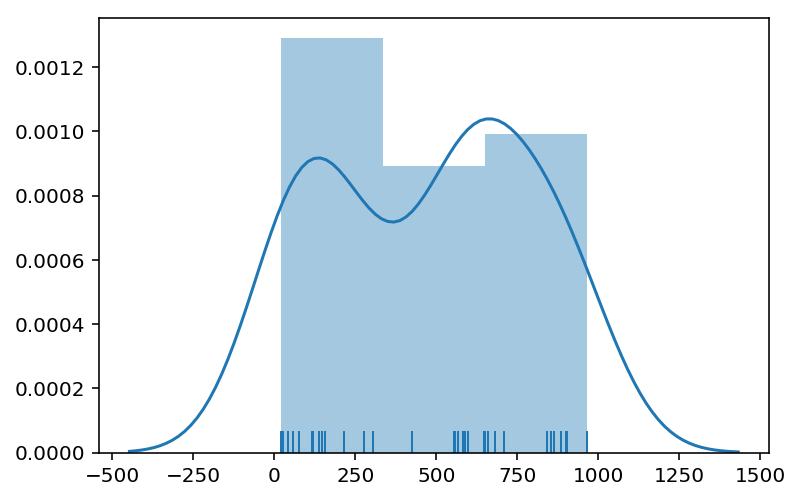

In [163]:
sns.distplot(realInSim_distance_list, rug=True)

真实值在预测值中的距离数据：
max distance : 946
min distance : 7
平均距离 : 556.65625
距离中位数 : 570.0
距离标准差 : 274.8418419490335

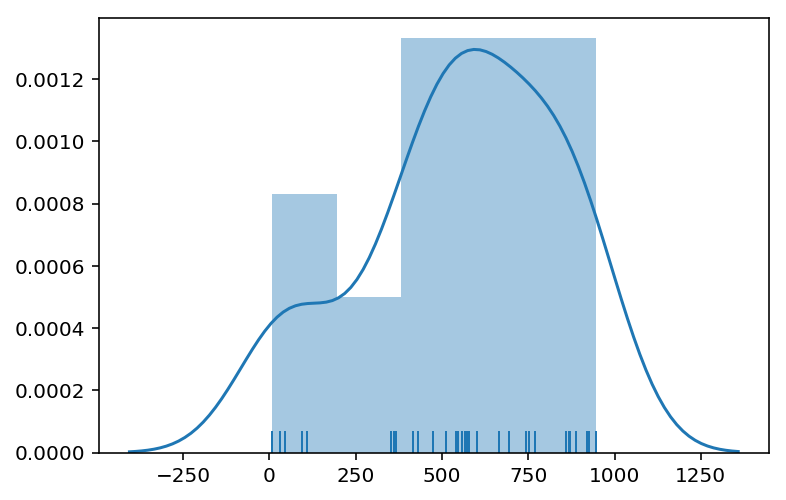

In [164]:
sns.distplot(realInPredict_distance_list, rug=True)

从最后一次的距离图表来看，模型训练的还不够好，从0到1000的距离都有可能，也就是没有学到规律。

## 显示训练Loss

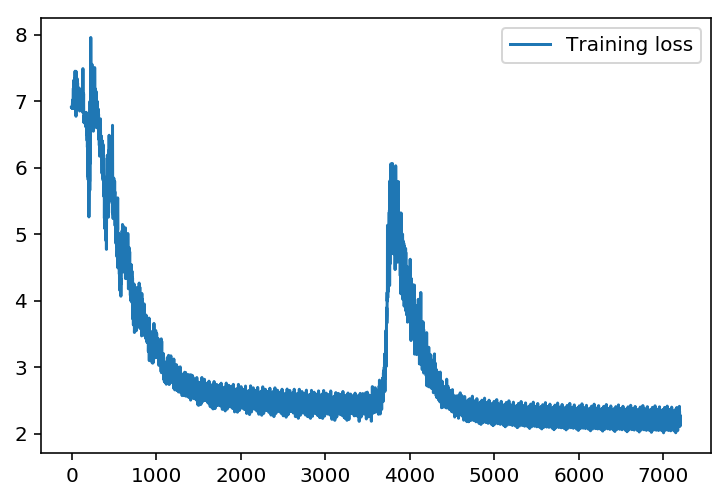

In [165]:
plt.plot(losses['train'], label='Training loss')
plt.legend()
_ = plt.ylim()

## 显示测试Loss
测试损失始终没有降下去。。。，epochs高一点的话会出现下降-上升-下降的波浪形曲线。

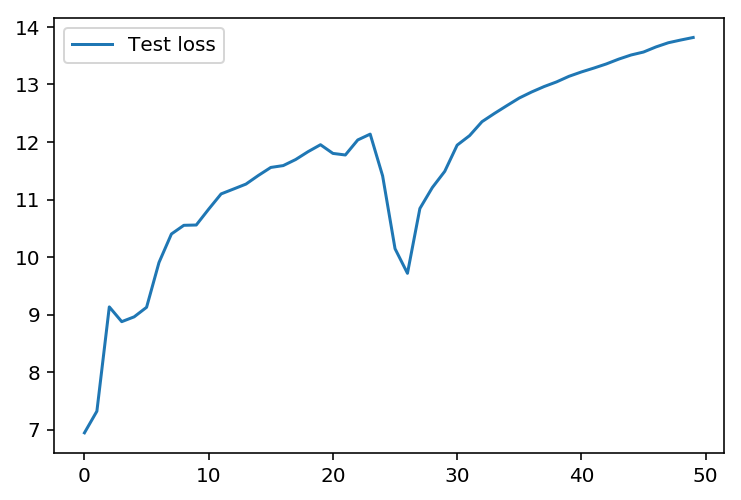

In [166]:
plt.plot(losses['test'], label='Test loss')
plt.legend()
_ = plt.ylim()

## 显示准确率
 - 测试准确率
 - Top K准确率
 - 相似度Top K准确率
 - 浮动距离中位数Range K准确率

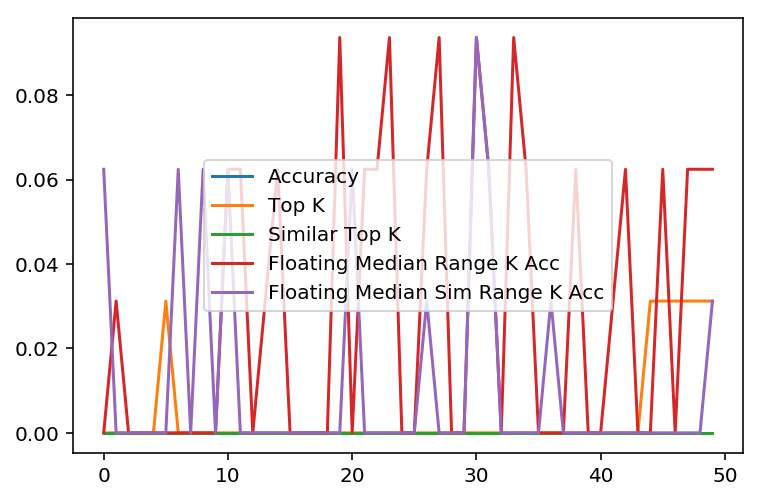

In [167]:
plt.plot(accuracies['accuracy'], label='Accuracy')
plt.plot(accuracies['topk'], label='Top K')
plt.plot(accuracies['sim_topk'], label='Similar Top K')
plt.plot(accuracies['floating_median_acc_range_k'], label='Floating Median Range K Acc')
plt.plot(accuracies['floating_median_sim_acc_range_k'], label='Floating Median Sim Range K Acc')
plt.legend()
_ = plt.ylim()

## 显示预测结果和实际开奖结果
感觉从趋势上看起来还行，实际结果是一个都没有猜中 ：P

有的简直错的离谱，南辕北辙

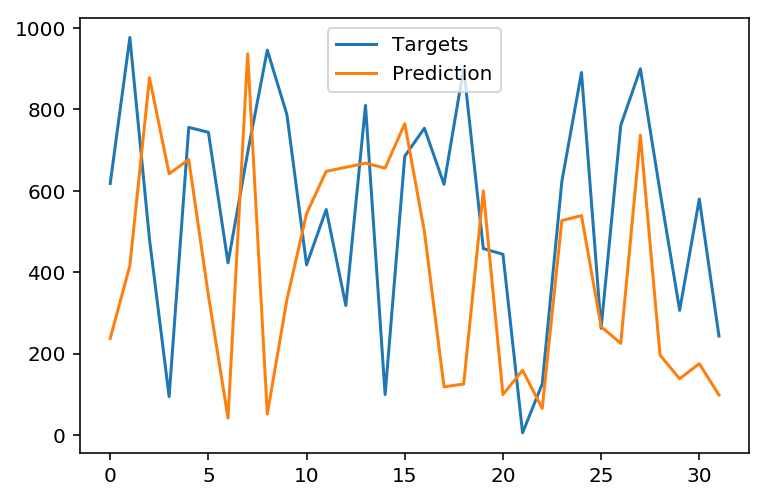

In [168]:
for batch_i, (x, y) in enumerate(test_batches):
    plt.plot(y, label='Targets')
    plt.plot(np.squeeze(probabilities.argmax(2)), label='Prediction')
    plt.legend()
    _ = plt.ylim()

## 保存参数
保存 `seq_length` 和 `save_dir` 在生成预测时使用。

In [169]:
# Save parameters for checkpoint
save_params((seq_length, save_dir))

# Checkpoint

In [17]:
import tensorflow as tf
import numpy as np

_, vocab_to_int, int_to_vocab = load_preprocess()
seq_length, load_dir = load_params()

## 生成往期开奖结果的相似度分布

In [171]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)
    
#     saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    embed_mat = sess.run(embed_matrix)

INFO:tensorflow:Restoring parameters from ./save


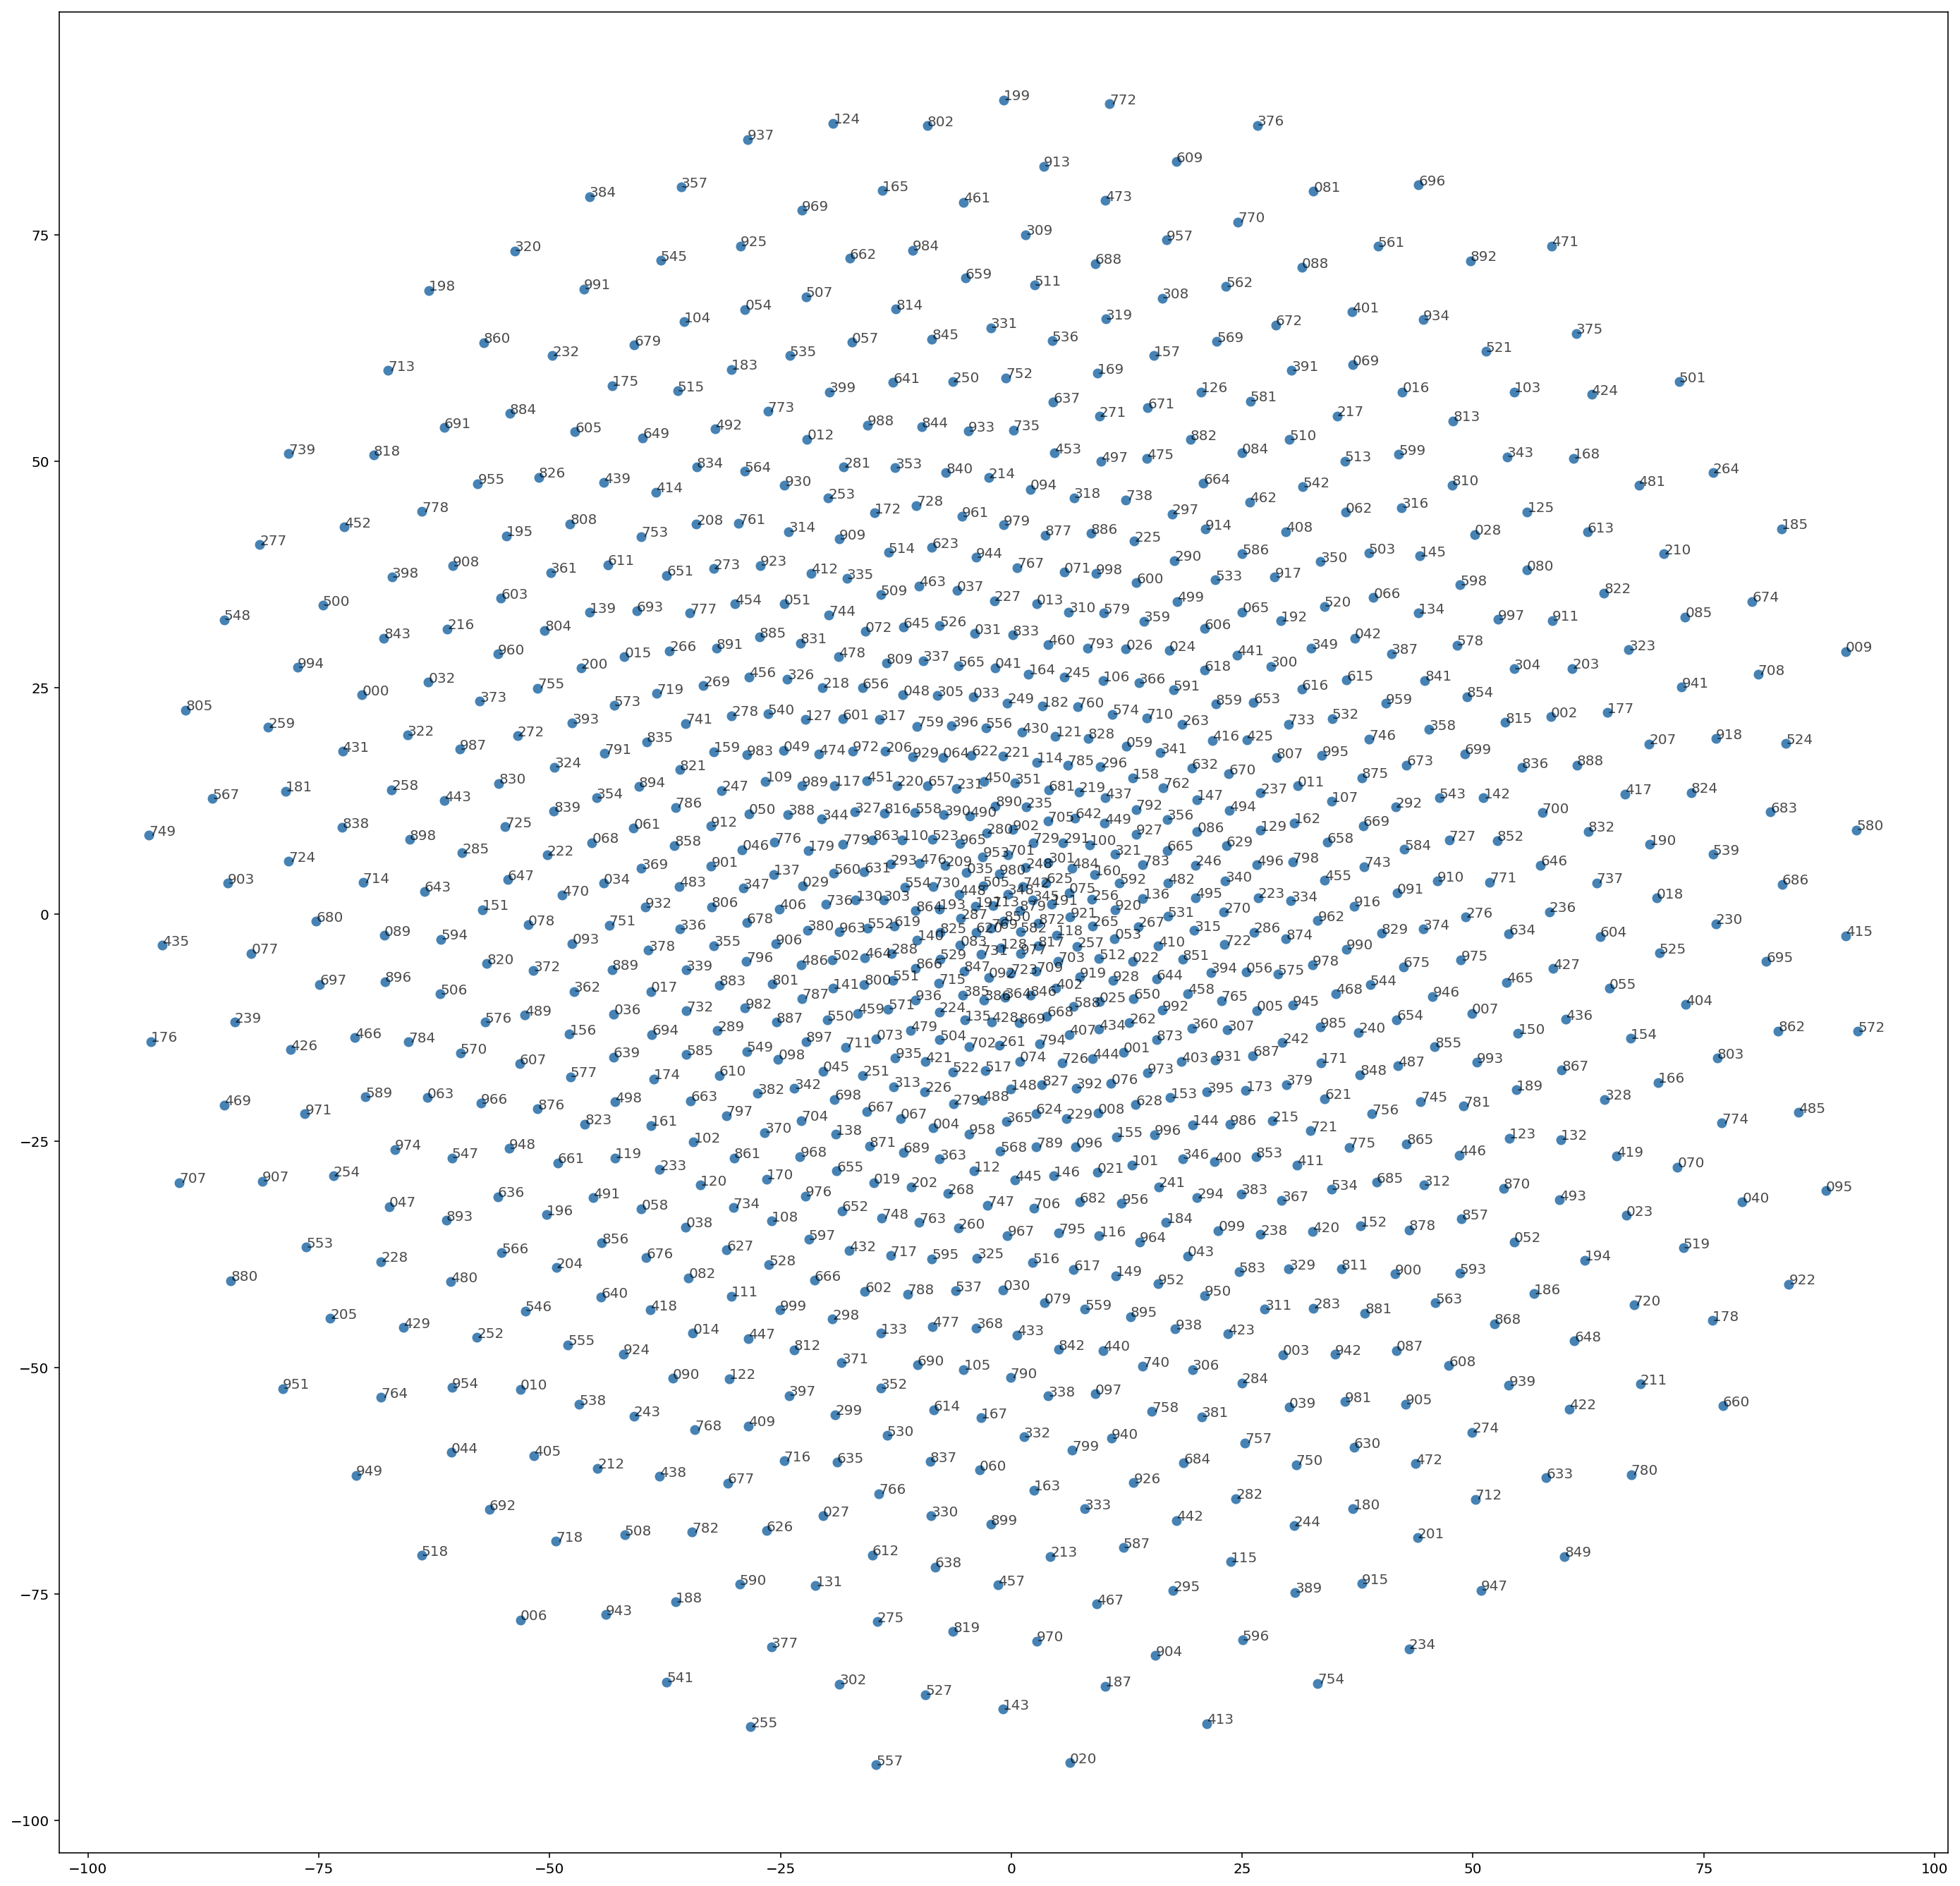

In [172]:
from sklearn.manifold import TSNE

viz_words = 1000
tsne = TSNE()
with train_graph.as_default():
    embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

fig, ax = plt.subplots(figsize=(24, 24))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)

在训练不够充分的情况下，从往期开奖的相互之间的距离图可以看出，大部分的数据点相互之间的距离基本上都差不多，完全符合彩票随机的特性，出现任何一种结果的概率都是一样的。甚至上一期和下一期之间的距离也有可能间隔非常远，只有一部分数据点之间联系的比较紧密，这部分数据点我们还可以试试运气。

## 实现生成预测函数
### 获取 Tensors
使用函数 [`get_tensor_by_name()`](https://www.tensorflow.org/api_docs/python/tf/Graph#get_tensor_by_name)从 `loaded_graph` 中获取tensors。  取得的 tensors 使用如下名字：
- "input:0"
- "initial_state:0"
- "final_state:0"
- "probs:0"


In [16]:
def get_tensors(loaded_graph):
    """
    Get input, initial state, final state, and probabilities tensor from <loaded_graph>
    :param loaded_graph: TensorFlow graph loaded from file
    :return: Tuple (InputTensor, InitialStateTensor, FinalStateTensor, ProbsTensor)
    """
    inputs = loaded_graph.get_tensor_by_name("input:0")
    initial_state = loaded_graph.get_tensor_by_name("initial_state:0")
    final_state = loaded_graph.get_tensor_by_name("final_state:0")
    probs = loaded_graph.get_tensor_by_name("probs:0")
    return inputs, initial_state, final_state, probs


### 选择号码
实现 `pick_word()` 函数从概率向量 `probabilities`或相似度向量`sim`中选择号码。

pred_mode是选择预测的种类：
- sim：从相似度向量Top K中选号。
- median：从浮动距离中位数（相似度向量）Range K中选号。
- topk：从概率向量Top K中选号。
- max：从概率向量中选择最大概率的号码。

In [18]:
def pick_word(probabilities, sim, int_to_vocab, top_n = 5, pred_mode = 'sim'):
    """
    Pick the next word in the generated text
    :param probabilities: Probabilites of the next word
    :param int_to_vocab: Dictionary of word ids as the keys and words as the values
    :param use_max: use max probabilities number
    :param top_n: Top number
    :return: String of the predicted word
    """
    vocab_size = len(int_to_vocab)

    if pred_mode == 'sim':
        p = np.squeeze(sim)
        p[np.argsort(p)[:-top_n]] = 0
        p = p / np.sum(p)
        c = np.random.choice(vocab_size, 1, p=p)[0]
        return int_to_vocab[c]
    elif pred_mode == 'median':
        p = np.squeeze(sim)
        p[np.argsort(p)[:floating_median_sim_idx - top_n]] = 0
        p[np.argsort(p)[floating_median_sim_idx + top_n:]] = 0
        p = np.abs(p) / np.sum(np.abs(p))
        c = np.random.choice(vocab_size, 1, p=p)[0]
        return int_to_vocab[c]
    elif pred_mode == 'topk':
        p = np.squeeze(probabilities)
        p[np.argsort(p)[:-top_n]] = 0
        p = p / np.sum(p)
        c = np.random.choice(vocab_size, 1, p=p)[0]
        return int_to_vocab[c]
    elif pred_mode == 'max':
        return int_to_vocab[probabilities.argmax()]


## 生成彩票号码
开始进行预测彩票了。
 - `gen_length` 作为你想生成多少期的号码。
 - `prime_word` 是前一期号码

In [23]:
gen_length = 17
prime_word = ["623", "891", "262", "761", "900", "598", "306", "580", "243", "202"]

loaded_graph = tf.Graph() 
with tf.Session(graph=loaded_graph) as sess:
    # Load saved model
    loader = tf.train.import_meta_graph(load_dir + '.meta')
    loader.restore(sess, load_dir)

    # Get Tensors from loaded model
    input_text, initial_state, final_state, probs = get_tensors(loaded_graph)  
    normalized_embedding = loaded_graph.get_tensor_by_name("truediv:0")
    # Sentences generation setup
    gen_sentences = []  # prime_word
    prev_state = sess.run(initial_state, {input_text: np.array([[1]])})
    
    x = np.zeros((1, 1))
    for word in prime_word:
        x[0,0] = vocab_to_int[word]
        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: x, initial_state: prev_state})

    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, probabilities.argmax())
    valid_embedding = tf.reshape(valid_embedding, (1, embed_dim))

    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))
    sim = similarity.eval()

    pred_word = pick_word(probabilities, sim, int_to_vocab, 5, 'topk')  # median  topk  max  sim
    gen_sentences.append(pred_word)
    
    # Generate sentences
    for n in range(gen_length):
        x[0,0] = pred_word

        # Get Prediction
        probabilities, prev_state = sess.run(
            [probs, final_state],
            {input_text: x, initial_state: prev_state})
        
        valid_embedding = tf.nn.embedding_lookup(normalized_embedding, probabilities.argmax())
        valid_embedding = tf.reshape(valid_embedding, (1, embed_dim))
        similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))
        sim = similarity.eval()
        
        pred_word = pick_word(probabilities, sim, int_to_vocab, 5, 'topk')  # median  topk  max  sim

        gen_sentences.append(pred_word)
    
    cp_script = ' '.join(gen_sentences)
    cp_script = cp_script.replace('\n ', '\n')
    cp_script = cp_script.replace('( ', '(')
        
    print(cp_script)

INFO:tensorflow:Restoring parameters from ./save
913 909 997 006 278 455 016 260 349 606 271 992 049 957 970 723 571 412


# 结论

先从数据上说，训练的最后打印出的准确率如下：

Epoch  49 floating median sim range k accuracy 0.01125 

Epoch  49 floating median range k accuracy 0.02875 

Epoch  49 similar top k accuracy 0.0 

Epoch  49 top k accuracy 0.004375 

Epoch  49 accuracy 0.0 

正常的开奖概率是1‰。

准确率和相似度向量top k一样都是0，一个都没猜中。。。

top k是4.3‰左右，但因为是top 10，所以实际上是0.43‰左右。

浮动中位数准确率在11.25‰~28.75‰之间，但由于这个范围range 10，所以实际上是1.125~2.875‰之间。

真没比正常开奖概率好多少。

从训练结果打印出的准确率，和往期开奖的相互之间的距离图都可以看得出来，想进行彩票预测实际上是不可行的。在排列三如此简单的、排列组合只有1000(样本空间已经足够小了)的等概率事件上进行预测都如此的困难，这也印证了数学的奇妙之处。都说了彩票是等概率，那么出任何一种号码都是有可能的，没有规律可言。惊不惊喜？意不意外？

## 新的思路
既然不能准确的预测，唯一能给我们提供思路的就是学习器学到的趋势，来看看下面的代码。

- int_sentences：里面保存着上面生成的若干期号码
- val_data：是最新几期的开奖号码，作为validate数据集

In [177]:
int_sentences = [int(words) for words in gen_sentences]
int_sentences = int_sentences[1:]

val_data = [[103],[883],[939],[36],[435],[173],[572],[828],[509],[723],[145],[621],[535],[385],[98],[321],[427]]

plt.plot(int_sentences, label='History')
plt.plot(val_data, label='val_data')
plt.legend()
_ = plt.ylim()

看得出来，虽然每期预测的号码不对，但是下一期号码的大概范围以及若干期号码的变化趋势学习的还可以，剩下的就要靠运气了：）

今天的分享就到这里，大家洗洗睡吧 ：）

In [26]:
# 913 909 997 006 278 455 016 260 349 606 271 992 049 957 970 723 571 412

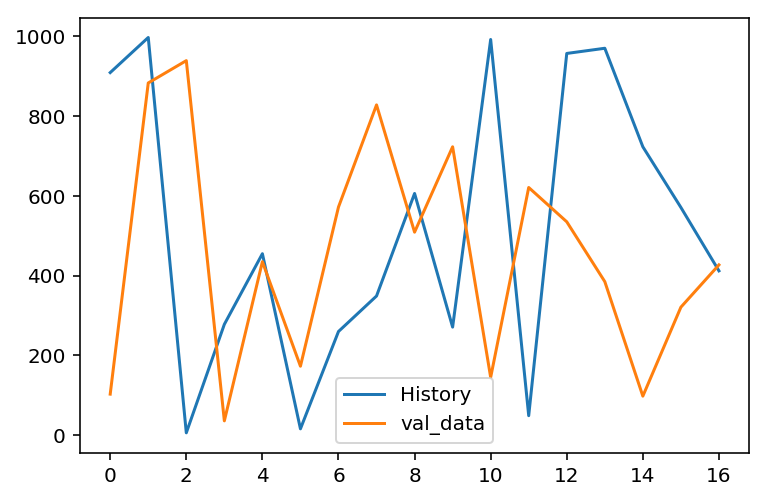

In [24]:
int_sentences = [int(words) for words in gen_sentences]
int_sentences = int_sentences[1:]

val_data = [[103],[883],[939],[36],[435],[173],[572],[828],[509],[723],[145],[621],[535],[385],[98],[321],[427]]
plt.plot(int_sentences, label='History')
plt.plot(val_data, label='val_data')
plt.legend()
_ = plt.ylim()